In [94]:
import cPickle as pickle
import pylab as plt
import numpy as np
import mptracker as mpt

results = pickle.load(open('tmp_results.p','r'))



[array([ 363.]), array([ 244.5])]


<IPython.core.display.Javascript object>


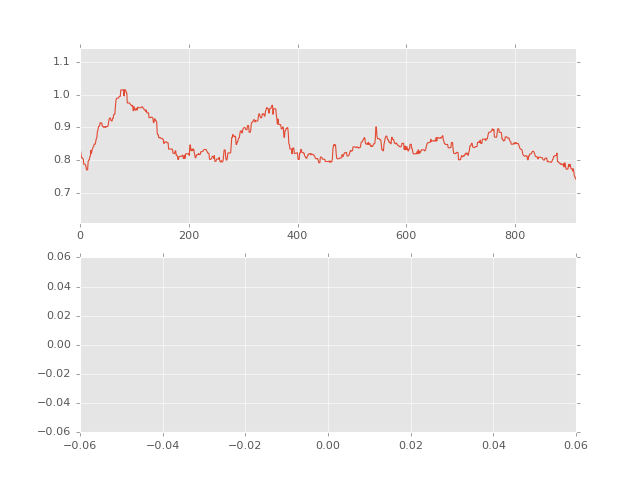

[[216, 264], [510, 225]]
[[  nan   nan]
 [  81.  217.]
 [  81.  217.]
 ..., 
 [  84.  219.]
 [  84.  219.]
 [  84.  219.]]


In [96]:
%matplotlib notebook
from scipy.signal import savgol_filter
from mptracker import medfilt,cart2sph

plt.matplotlib.style.use('ggplot')



def computePupilDiameterFromEllipse(ellipsePix,conversionFactor = None, smoothing = 'medfilt'):
    ''' diam = computePupilDiameterFromEllipse(ellipsePix,conversionFactor = None, smoothing = 'medfilt')
        ellipsePix is a Nx2 array (short_axis,long_axis)
        Compute the pupil diameter as the diameter of a circle with the same area as the fitted ellipse.
            Conversion factor (mm per pixel)
            Smoothing can be None, medfilt or sgolay.
    '''
    diam = np.sqrt(ellipsePix[:,0]*ellipsePix[:,1])*2
    if not conversionFactor is None:
        diam *= conversionFactor
    if smoothing is None or smoothing.lower() == 'none':
        return diam
    elif smoothing.lower() == 'medfilt':
        return medfilt(diam)
    elif smoothing.lower() == 'sgolay':
        return savgol_filter(diam, window_length = 5, polyorder = 1, mode='nearest')


def computeConversionFactor(ref,estimate = 6.0):
    return float(estimate)/np.sqrt(np.diff([ref[0][0],ref[1][0]])**2. + np.diff([ref[0][1],ref[1][1]])**2.)


diam = computePupilDiameterFromEllipse(results['diamPix'],computeConversionFactor(results['reference']))


def convertPixelToEyeCoords(pupilPix,
                            eyeCorners,
                            crPix = None,
                            eyeDiameterEstimate = 6.0):
    reference = [eyeCorners[0][0] + np.diff([eyeCorners[0][0],eyeCorners[1][0]])/2.,
                 eyeCorners[0][1] + np.diff([eyeCorners[0][1],eyeCorners[1][1]])/2.]
    print reference
    if not crPix is None:
        pupilPix[:,0] = pupilPix[:,0] - (crPix[:,0] - np.nanmean(crPix[0,0]))
        pupilPix[:,1] = pupilPix[:,1] - (crPix[:,1] - np.nanmean(crPix[0,1]))
    cFactor = computeConversionFactor(eyeCorners)
    [az,el,theta] = cart2sph((pupilPix[:,0]-reference[0])*cFactor,(pupilPix[:,1]-reference[1])*cFactor,
                             eyeDiameterEstimate/2.)
    return az,el,theta
az,el,theta = convertPixelToEyeCoords(results['pupilPix'],results['reference'],results['crPix'].copy())
plt.subplot(2,1,1)
plt.plot(diam)
plt.subplot(2,1,2)
plt.plot(medfilt(az))
#plt.plot(medfilt(theta))

print results['reference']
print results['crPix']

In [3]:
from glob import glob 
import os
files = np.sort(glob('./../pupil_tracking_mice/160927_JC021_lgnmov/*.tif'))

filenames = [f for f in files]
target =  filenames[0]
print target
imgstack = mpt.TiffFileSequence(target)

./../pupil_tracking_mice/160927_JC021_lgnmov/160927155101_JC021_lgnmov_0000.tif


<IPython.core.display.Javascript object>


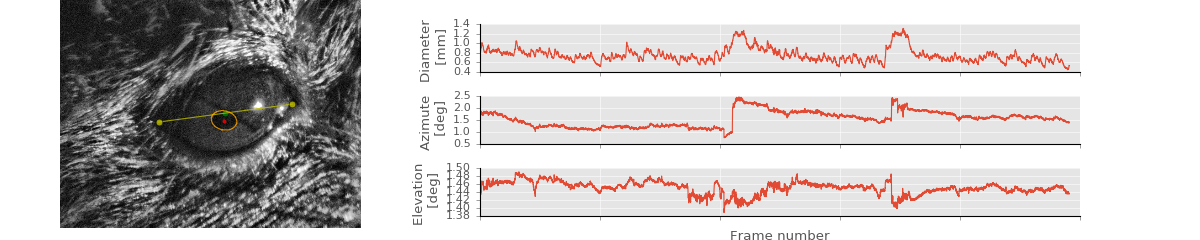

In [87]:
%matplotlib notebook
import cv2
clahe = cv2.createCLAHE(5,(10,10))
ii = 90
img = clahe.apply(imgstack.get(ii))
fig = plt.figure(figsize = [15,3])
ax = fig.add_axes([0.05,0.05,0.25,0.95],aspect='equal')
ax.imshow(img,cmap='gray',aspect='equal')
eyeCorners  = results['reference']
reference = [eyeCorners[0][0] + np.diff([eyeCorners[0][0],eyeCorners[1][0]])/2.,
             eyeCorners[0][1] + np.diff([eyeCorners[0][1],eyeCorners[1][1]])/2.]
ax.plot(reference[0],reference[1],'go',alpha=0.8)
ax.plot([results['reference'][0][0],results['reference'][1][0]],
         [results['reference'][0][1],results['reference'][1][1]],'-oy',alpha=0.8)
ax.plot(results['pupilPix'][ii,0],results['pupilPix'][ii,1],'r.',alpha=0.8)
s1 = mpt.ellipseToContour(results['pupilPix'][ii,:],results['diamPix'][ii,2],
                          results['diamPix'][ii,3],results['diamPix'][ii,4],np.linspace(0,2*np.pi,200))

ax.plot(np.hstack([s1[:,0,1],s1[0,0,1]]),np.hstack([s1[:,0,0],s1[0,0,0]]),'-',color='orange',alpha=0.8)
ax.grid('off')
ax.axis('off');ax.axis('tight');
axdiam = fig.add_axes([0.4,0.7,0.5,0.2])
axaz = fig.add_axes([0.4,0.4,0.5,0.2],sharex=axdiam)
axel = fig.add_axes([0.4,0.1,0.5,0.2],sharex=axdiam)
diam = computePupilDiameterFromEllipse(results['diamPix'],computeConversionFactor(results['reference']))
az,el,theta = convertPixelToEyeCoords(results['pupilPix'],results['reference'])
axdiam.plot(medfilt(diam));axdiam.set_xticklabels([])
axaz.plot(medfilt(az));axaz.set_xticklabels([]);axaz.set_ylabel('Azimute \n [deg]')
axel.plot(medfilt(el));axel.set_ylabel('Elevation \n [deg]')
axdiam.set_ylabel('Diameter \n [mm]')
axel.set_xlabel('Frame number')
def cleanAx(ax1):
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')
    ax1.spines['bottom'].set_color('black')
    ax1.spines['left'].set_color('black')
for a in [axdiam,axaz,axel]:
    cleanAx(a)
